In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [206]:
data_name = 'Sales_Data_CSV.csv'
data_raw = pd.read_csv(data_name)
data_clean = data_raw.copy()


data_clean['sales'] = [int(s.replace(',', '')) for s in data_raw['sales'].astype(str)]


priority_to_int = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
data_clean['order_priority'] = [priority_to_int[p] for p in data_raw['order_priority']]


data_clean.insert(17, 'profit_per_item', data_clean['profit'] / data_clean['quantity'])


ship_mode_to_int = {'Standard Class': 0, 'Second Class': 1, 'Same Day': 2, 'First Class': 3}
data_clean['ship_mode'] = [ship_mode_to_int[m] for m in data_raw['ship_mode']]


data_clean['order_date'] = pd.to_datetime(
    [s.replace('-', '/') for s in data_clean['order_date']], dayfirst=True,
)
data_clean['ship_date'] = pd.to_datetime(
    [s.replace('-', '/') for s in data_clean['ship_date']], dayfirst=True,
)

# for col in data_clean.columns:
#     if not (np.issubdtype(data_clean[col].dtype, np.number) or data_clean[col].dtype == np.datetime64):
#         data_clean[col] = data_clean[col].astype(str)


data_clean.insert(2, 'order_day', data_clean['order_date'].dt.day)
data_clean.insert(2, 'order_month', data_clean['order_date'].dt.month)
data_clean.insert(2, 'order_year', data_clean['order_date'].dt.year)


data_clean.insert(6, 'ship_day', data_clean['ship_date'].dt.day)
data_clean.insert(6, 'ship_month', data_clean['ship_date'].dt.month)
data_clean.insert(6, 'ship_year', data_clean['ship_date'].dt.year)


def get_metadata(df):
    def get_minmax(col, is_min=False):
        if np.issubdtype(df[col].dtype, np.number):
            return df[col].min() if is_min else df[col].max()
        if df[col].dtype == 'datetime64[ns]':
            return df[col].min().date() if is_min else df[col].max().date()
        else:
            return np.NaN
                
    md_list = [
        [col, df[col].dtype, df[col].unique().size,
         get_minmax(col, is_min=False), get_minmax(col, is_min=True)
        ] for col in df.columns
    ]
    return pd.DataFrame(md_list, columns=['column', 'data_type', 'unique_values', 'max_value', 'min_value'])


print(get_metadata(data_clean))

             column       data_type  unique_values   max_value   min_value
0          order_id          object          25035         NaN         NaN
1        order_date  datetime64[ns]           1430  2014-12-31  2011-01-01
2        order_year           int32              4        2014        2011
3       order_month           int32             12          12           1
4         order_day           int32             31          31           1
5         ship_date  datetime64[ns]           1464  2015-01-07  2011-01-03
6         ship_year           int32              5        2015        2011
7        ship_month           int32             12          12           1
8          ship_day           int32             31          31           1
9         ship_mode           int64              4           3           0
10    customer_name          object            795         NaN         NaN
11          segment          object              3         NaN         NaN
12            state      

In [286]:
df = data_clean#[data_clean['region'] == 'Africa']

df1 = df.groupby('order_date').size()[:10]
print(df1)
print()

print(df1.resample('1D').sum())
print()

df2 = df.set_index('order_date').resample('1D').size()[:14]
print(df2 - df1.resample('1D').sum())

order_date
2011-01-01     6
2011-01-02     1
2011-01-03    20
2011-01-04    16
2011-01-05     7
2011-01-06     8
2011-01-07    25
2011-01-08     9
2011-01-09     8
2011-01-10    25
dtype: int64

order_date
2011-01-01     6
2011-01-02     1
2011-01-03    20
2011-01-04    16
2011-01-05     7
2011-01-06     8
2011-01-07    25
2011-01-08     9
2011-01-09     8
2011-01-10    25
Freq: D, dtype: int64

order_date
2011-01-01    0.0
2011-01-02    0.0
2011-01-03    0.0
2011-01-04    0.0
2011-01-05    0.0
2011-01-06    0.0
2011-01-07    0.0
2011-01-08    0.0
2011-01-09    0.0
2011-01-10    0.0
2011-01-11    NaN
2011-01-12    NaN
2011-01-13    NaN
2011-01-14    NaN
Freq: D, dtype: float64


1459
0.016350665805481567
DatetimeIndex(['2011-01-02', '2014-12-30'], dtype='datetime64[ns]', freq=None)


<Axes: xlabel='y(t)', ylabel='y(t + 30)'>

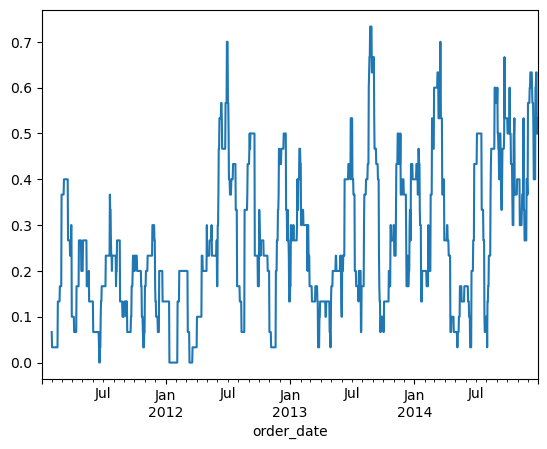

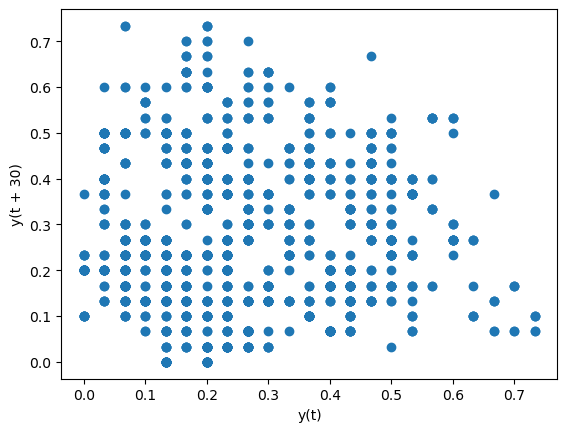

In [313]:
def get_order_count(df, group_by='order_date', fill_dates=True, **kwargs):
    for col, cond in kwargs.items():
        if isinstance(cond, tuple):
            df = df[(df[col] >= cond[0]) & (df[col] <= cond[1])]
        elif isinstance(cond, list):
            df = df[df[col].isin(cond)]
        else:
            df = df[df[col] == cond]
    if fill_dates and df[group_by].dtype == 'datetime64[ns]':
        return df.set_index(group_by).resample('1D').size()
    return df.groupby(group_by).size()

    

df_test = get_order_count(
    data_clean,
    fill_dates=True,
    # order_year=2011,
    # order_month=1,
    region='Canada',
).rolling(window=30).mean()

print(df_test.shape[0])

print(df_test.autocorr(lag=30))
ax = df_test.plot()
print(pd.to_datetime(ax.get_xlim(), unit='D'))
plt.figure()
pd.plotting.lag_plot(df_test, lag=30)

<Axes: >

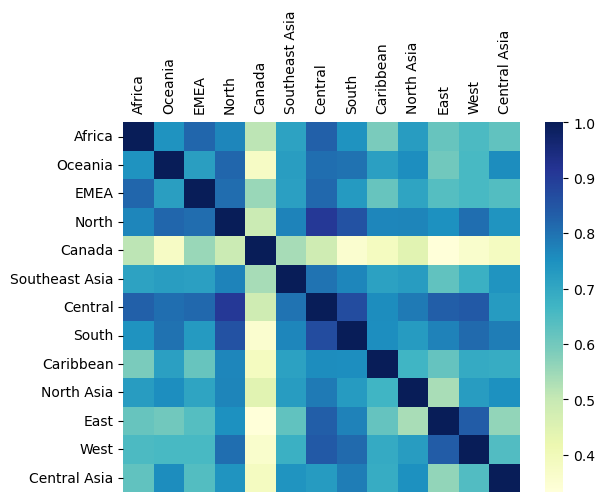

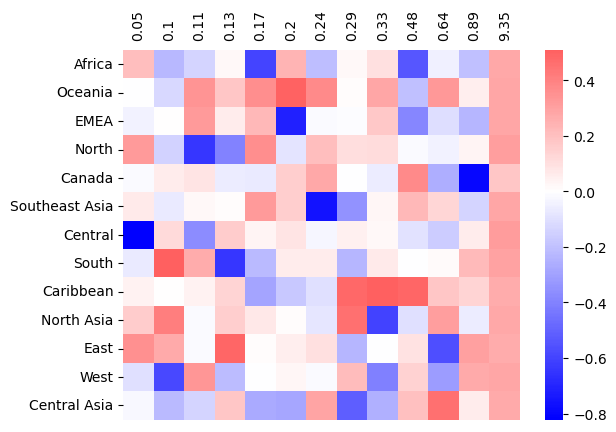

In [331]:
window = 30
lag = 30
threshold = 0.4
corr_method = 'pearson'
regions = data_clean['region'].unique()

order_count_df = pd.DataFrame(
    dict(
        (
            region,
            get_order_count(
                data_clean,
                region=region
            ).rolling(window=30).mean()
        )
    for region in regions
    )
)

# auto_corr_table = order_count_df.apply(lambda x: x.autocorr(lag=lag))
# print(auto_corr_table)


corr_matrix = order_count_df.corr(method=corr_method)

plt.tick_params(
    axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True
)
sns.heatmap(corr_matrix, cmap="YlGnBu")


eigvals, eigvecs = np.linalg.eigh(corr_matrix)
corr_eig_df = pd.DataFrame(eigvecs, index=regions, columns=np.round(eigvals, 2))
plt.figure()
plt.tick_params(
    axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True
)
sns.heatmap(corr_eig_df, center=0, cmap="bwr")


# plt.figure(figsize=(12,8), dpi=100)
# for region, count in order_count_table:
#     if auto_corr_table[region] <= threshold:
#         count.plot(label=region)
# plt.title('Auto corr <= {}'.format(threshold))
# plt.legend()


# plt.figure(figsize=(12,8), dpi=100)
# for region, count in order_count_table:
#     if auto_corr_table[region] > threshold:
#         count.plot(label=region)
# plt.title('Auto corr > {}'.format(threshold))
# plt.legend()

In [204]:
order_count_df = pd.DataFrame(
    dict(
        (
            region,
            get_order_count(
                data_clean,
                region=region
            ).rolling(window=window).mean()
        )
    for region in data_clean['region'].unique()
    )
)


df = get_order_count(data_clean, region='Africa').rolling(window=30).mean()
# print(df)
# print(df.autocorr(lag=30))

print(df)
print()
print(order_count_df['Africa'].loc[order_count_df.index.difference(df.index)])

# plt.figure(figsize=(12,8), dpi=100)
# order_count_df['Africa'].plot(label='order_count_df')
# df.plot(label='df')
# plt.legend()

order_date
2011-01-01         NaN
2011-01-03         NaN
2011-01-04         NaN
2011-01-06         NaN
2011-01-07         NaN
                ...   
2014-12-27    7.833333
2014-12-28    7.766667
2014-12-29    7.200000
2014-12-30    7.300000
2014-12-31    7.000000
Length: 1009, dtype: float64

order_date
2011-01-02   NaN
2011-01-05   NaN
2011-01-09   NaN
2011-01-11   NaN
2011-01-16   NaN
              ..
2014-11-16   NaN
2014-11-23   NaN
2014-12-06   NaN
2014-12-14   NaN
2014-12-21   NaN
Name: Africa, Length: 421, dtype: float64


In [205]:
# print(data_clean.groupby(['category', 'sub_category']).size())
for region in data_clean['region'].unique():
    print(data_clean[data_clean['region'] == region].groupby(['region', 'country', 'market']).size())
    print()

region  country                           market
Africa  Algeria                           Africa    196
        Angola                            Africa    122
        Benin                             Africa     35
        Burundi                           Africa      2
        Cameroon                          Africa    110
        Central African Republic          Africa      7
        Chad                              Africa      2
        Cote d'Ivoire                     Africa    109
        Democratic Republic of the Congo  Africa    379
        Djibouti                          Africa     12
        Egypt                             Africa    487
        Equatorial Guinea                 Africa      3
        Eritrea                           Africa      2
        Ethiopia                          Africa      7
        Gabon                             Africa     14
        Ghana                             Africa    102
        Guinea                            Africa     18

In [68]:
# print(data_clean['region'].unique())

print(
    data_clean[data_clean['region'].isin([
        'West',
        'Canada',
        # 'EMEA'
    ])].groupby(['country', 'state']).size()
)

country        state           
Canada         Alberta               49
               British Columbia      46
               Manitoba              14
               Newfoundland           1
               Nova Scotia            3
               Ontario              198
               Quebec                57
               Saskatchewan          16
United States  Arizona              224
               California          2001
               Colorado             182
               Idaho                 21
               Montana               15
               Nevada                39
               New Mexico            37
               Oregon               124
               Utah                  53
               Washington           506
               Wyoming                1
dtype: int64


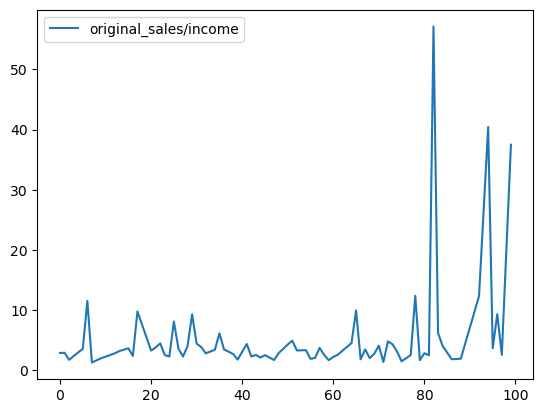

In [57]:
n = 100

income = data_clean['profit'][:n] + data_clean['shipping_cost'][:n]
sales = data_clean['sales'][:n]
discount = data_clean['discount'][:n]
original_sales = sales / (1 - discount)

# plt.plot(income, label='income')
# # # plt.plot(sales, label='sales')
# plt.plot(original_sales, label='original_sales')
plt.plot(original_sales[income > 0]/income[income > 0], label='original_sales/income')
plt.legend()